# Weather housing analysis notebook

Author: [Spencer Bertsch](https://github.com/spencerbertsch1)  
August 2021

This project idea came from my friend James who is a fullstack software developer in Sad Diego. He told me that he and his fiance love the weather in San Diego, but they'd like to live in a city with less expensive housing options. Data analytics to the rescue. 

This notebook is designed to load two data sets into memory and use the data to answer a few questions: 

1. What cities in the united states have weather similar to San Diego? (Dry heat, similar seasonal temperatures, etc) 
2. What are the housing prices like in those similar cities? More expensive? Less expensive? 

Data Sources: 
1. [Kaggle - Historical Hourly Weather Data 2012-2017](https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=wind_speed.csv)
2. [Kiplinger - Home Prices in the 100 Largest Metro Areas](https://www.kiplinger.com/article/real-estate/t010-c000-s002-home-price-changes-in-the-100-largest-metro-areas.html)


In [1]:
# Note: 
# If the theme of jupyter lab is in "Dark Mode" you won't be able to see the axis labels
# TO CHANGE THEME --> Settings --> Theme --> JupyterLab (Light/Dark)

from pathlib import Path 
import pathlib
from enum import Enum
from typing import Dict

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use("fivethirtyeight")
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

import matplotlib.cm as cm
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

### Define Notebook Variables
- Try ('monthly' and 'dtw') or ('weekly' and 'mse') to see how the calculation method impacts the results
- Note that the dynamic time warping calculations take a long time, so it's best to use 'monthly' time aggregations with the 'dtw' calculation method

In [2]:
time_agg = 'weekly'  # 'daily', 'weekly', 'monthly'
error_type = 'mse'  # 'rmse', 'mse', 'dtw'

In [3]:
ABSPATH_TO_NOTEBOOK: Path = pathlib.Path().absolute()
ABSPATH_TO_DATA: Path = ABSPATH_TO_NOTEBOOK / 'data'
    
time_mapper: Dict[str, str] = {
    'monthly': 'M',
    'weekly': 'W',
    'daily': 'D'
}

### Load weather data for the United States

Weather data includes the following features: 

* Temperature
* Humidity
* Air pressure
* Weather description ("scattered clouds", "light rain", etc.) 
* Wind speed 

In [4]:
## todo - read the files directly from S3 instead of loading from disk

In [5]:
class weather_data:

    weather_metrics = ['temperature', 'humidity', 'pressure', 'wind_speed']
    
    def __init__(self, data_path: Path, time_frequency: str):
        self.data_path = data_path
        self.time_frequency = time_frequency
        self.temperature = self.load_csv(fname=self.weather_metrics[0])
        self.humidity = self.load_csv(fname=self.weather_metrics[1])
        self.air_pressure = self.load_csv(fname=self.weather_metrics[2])
        self.wind_speed = self.load_csv(fname=self.weather_metrics[3])

    def load_csv(self, fname: str):
        fname+='.csv'
        full_path: Path = self.data_path / fname
        df = pd.read_csv(full_path, sep=',')
        df.index = pd.to_datetime(df['datetime'],format='%Y/%m/%d %H:%M:%S')
        # aggregate monthly instead of hourly 
        df = df.groupby(pd.Grouper(freq=self.time_frequency)).transform(np.mean).drop_duplicates()
        # remove non-US columns
        df = df.iloc[:, :-6]
        return df
    
    def __repr__(self):
        return '\n'.join([
        f'Total cities: {self.temperature.shape[1]}',
        f'Total number of monthly weather samples: {self.temperature.shape[0]}',
        f'Weather metrics imported: {self.weather_metrics}'
        ])
    

In [6]:
%%time
wd = weather_data(data_path=ABSPATH_TO_DATA, time_frequency=time_mapper[time_agg])
wd

CPU times: user 4.31 s, sys: 88.7 ms, total: 4.39 s
Wall time: 4.4 s


Total cities: 30
Total number of monthly weather samples: 270
Weather metrics imported: ['temperature', 'humidity', 'pressure', 'wind_speed']

In [7]:
wd.temperature.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,285.008019,287.436972,292.404145,285.364647,294.643467,294.500153,299.239221,300.877976,291.003271,282.981460,...,287.732209,299.012906,292.931562,300.687268,289.019417,287.341592,291.336710,291.751748,287.209794,289.803653
2012-10-08 00:00:00,284.720833,285.642262,288.176220,286.034792,291.513393,291.938185,293.942500,297.743244,286.328452,282.160298,...,281.436399,295.836548,286.585923,299.787589,280.794464,280.671369,283.179583,283.863006,280.680536,283.120714
2012-10-15 00:00:00,283.916726,285.731905,291.387708,285.012708,294.941369,294.401399,293.943333,297.619315,287.568958,285.852232,...,285.918988,295.522381,288.202440,299.697113,285.910982,283.635565,287.110804,287.540119,282.993378,286.240893
2012-10-22 00:00:00,279.670387,281.088631,287.071310,280.389077,292.391905,291.126429,291.052887,295.278095,285.027976,280.840952,...,287.274018,295.285982,289.262500,298.417917,288.503095,284.207708,287.530982,287.641905,282.580521,284.681964
2012-10-29 00:00:00,283.856786,286.729613,288.123899,285.597649,290.684137,290.443095,290.476280,294.542500,284.611756,283.178036,...,278.627500,289.107619,283.365595,293.455744,277.846369,278.926458,282.226012,283.918929,282.975089,284.562946


### Visualize city temperatures 

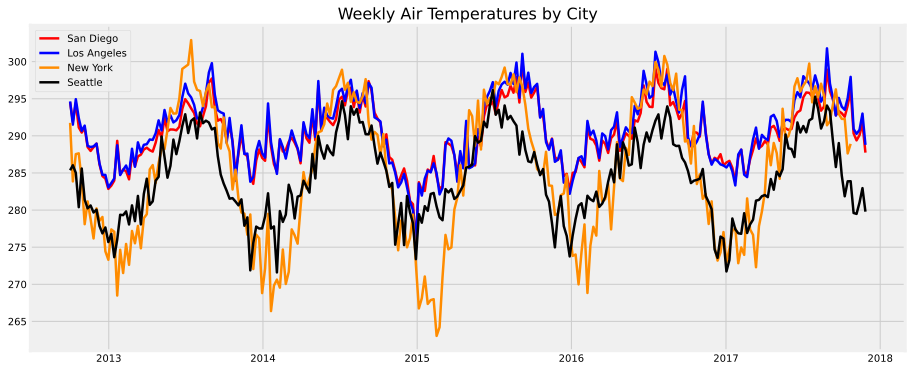

In [8]:
figure(figsize=(14, 6), dpi=80)
plt.plot(wd.temperature.index, wd.temperature['San Diego'], label = "San Diego", linestyle="-", color='red', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Los Angeles'], label = "Los Angeles", linestyle="-", color='blue', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['New York'], label = "New York", linestyle="-", color='darkorange', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Seattle'], label = "Seattle", linestyle="-", color='black', linewidth=2.5)
plt.title(f'{time_agg.capitalize()} Air Temperatures by City', fontsize=16)
plt.legend()
plt.show()

### Visualize city humidities 

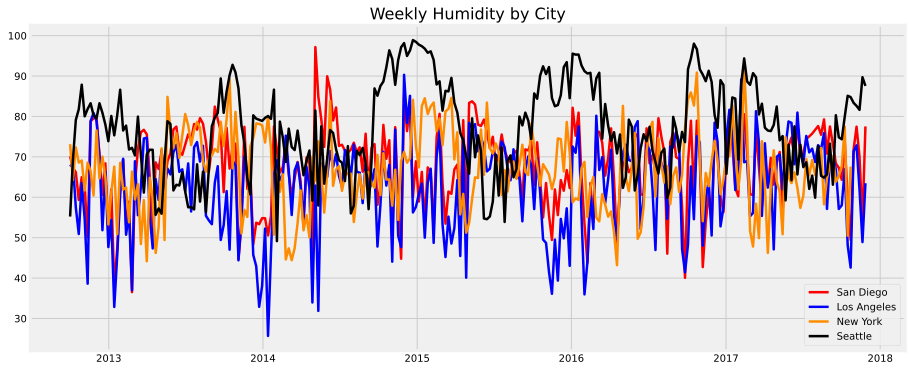

In [9]:
figure(figsize=(14, 6), dpi=80)
plt.plot(wd.humidity.index, wd.humidity['San Diego'], label = "San Diego", linestyle="-", color='red', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['Los Angeles'], label = "Los Angeles", linestyle="-", color='blue', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['New York'], label = "New York", linestyle="-", color='darkorange', linewidth=2.5)
plt.plot(wd.humidity.index, wd.humidity['Seattle'], label = "Seattle", linestyle="-", color='black', linewidth=2.5)
plt.title(f'{time_agg.capitalize()} Humidity by City', fontsize=16)
plt.legend()
plt.show()

### Reformat the data to create a dataframe with 2 or 3 columns: 

* Temperature
* Humidity
* City (encoded or not encoded)

In [10]:
city_names_vec = []
for col in wd.humidity.columns:
    for i in range(wd.humidity.shape[0]):
        city_names_vec.append(col)

In [11]:
def vectorize_dataframe(df: pd.DataFrame) -> dict:
    data_dict = {}
    for (col_name, col_data) in df.iteritems():
        data_dict[col_name] = col_data.values
    return data_dict
        
temp_dict = vectorize_dataframe(df=wd.temperature)
humidity_dict = vectorize_dataframe(df=wd.humidity)
air_pressure_dict = vectorize_dataframe(df=wd.air_pressure)
wind_speed_dict = vectorize_dataframe(df=wd.wind_speed)

In [12]:
def weather_scatter(n1: str, n2: str, dict1: dict, dict2: dict, num_cities_to_plot: int = 6):
    figure(figsize=(14, 10), dpi=80)
    hex_codes = ['#AB47BC', '#7E57C2', '#5C6BC0', '#42A5F5', '#29B6F6', '#FF3D00']
    counter = 0
    for (city, temp_data), (city, humidity_data), hex_code in zip(dict1.items(), dict2.items(), hex_codes):
        counter+=1
        alpha=0.5
        s=40
        if counter > num_cities_to_plot: 
            continue
            
        if city == 'San Diego':
            alpha=1
            s=90

        plt.scatter(temp_data, 
                    humidity_data,  
                    s=s, 
                    c=hex_code,
                    label=city,
                    alpha=alpha, 
                    marker='s',
                    linewidths=0.5,
                    edgecolors='black',
                    cmap='magma')

    plt.xlabel(n1, fontsize=14)
    plt.ylabel(n2, fontsize=14)
    plt.legend()
    plt.title(f'{time_agg.capitalize()}{n1} vs {n2}')
    plt.show()

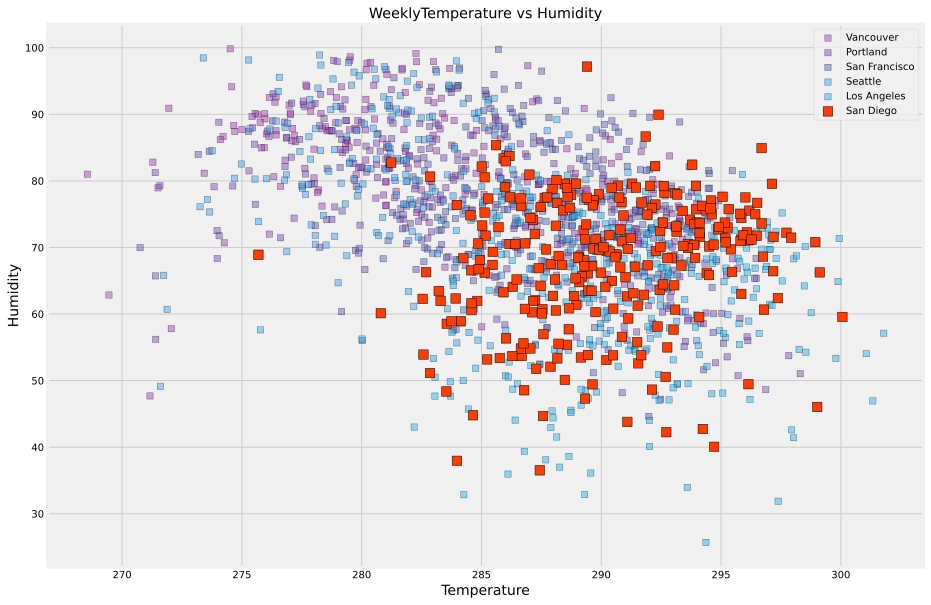

In [13]:
weather_scatter(n1='Temperature', n2='Humidity', dict1=temp_dict, dict2=humidity_dict)

Difficult to see what city is similar... we can rely on the below methods:

# Which cities have the most similar weather? 

At this point we have a good idea what our data looks like, and now we have to ask ourselves the most important question in this analysis: 

- How do we determine similarity for weather between cities? 

### Distance between centroids?

* Cosine similarity
* Covariance matrices
* MAPE - mean absolute percentage error
* ARIMA model - compare coefficients and use distance metric on those

* distinct covariance matrices
* covariance matrix with all vectors 

### Generate Correlation Matrices on all data sets individually

In a first attempt, we create four heatmaps of the lower triangular matrices for each weather metric representing the correlation between each city in our data set. Remember that the correlation between any city and itself is one, so we exclude the main diagonal because it doesn't offer us any additional informatin. We also know that the matrix will be symmetric about the main diagonal, so we only need to plot the lower or upper trangular matrix here. It's convention to plot the lower triangular, so that's what we do. 

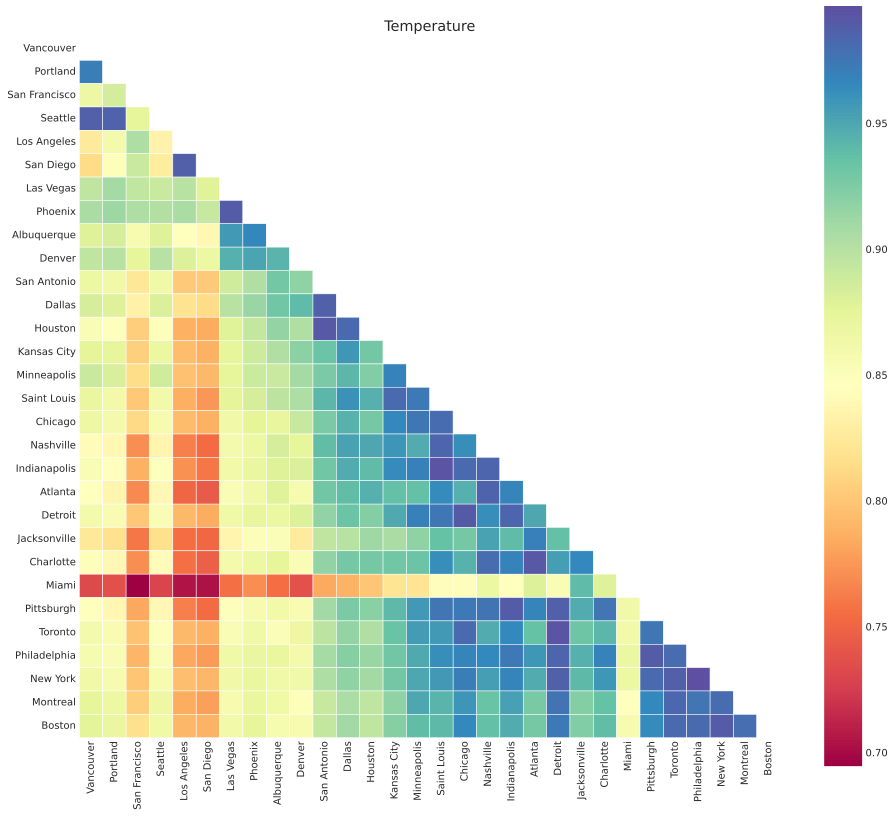

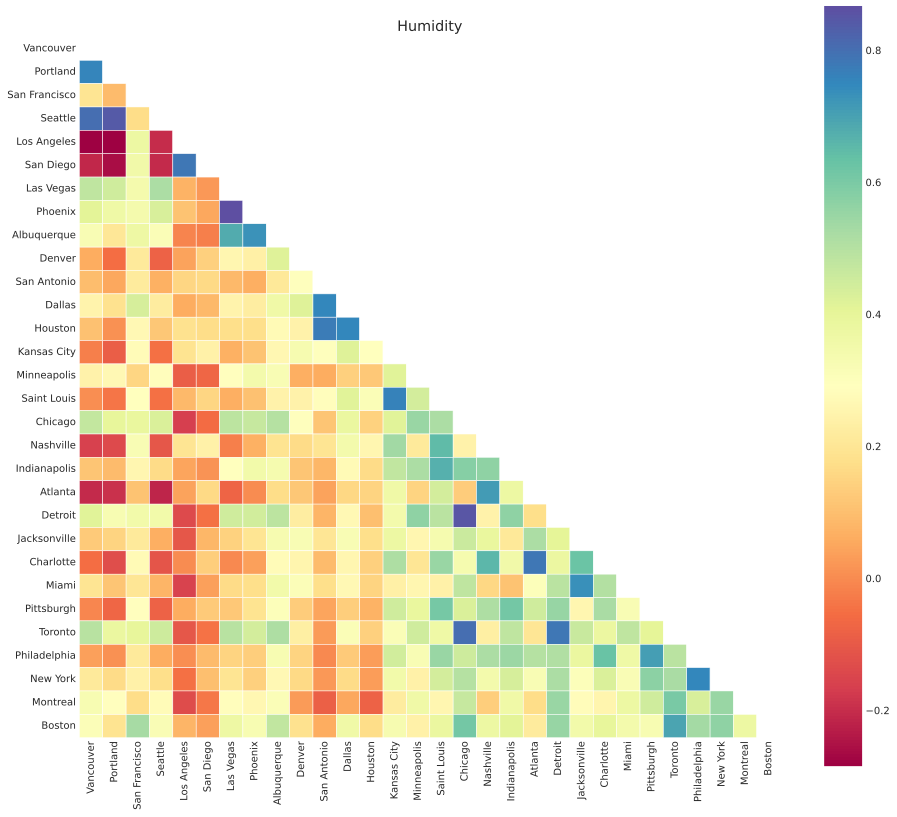

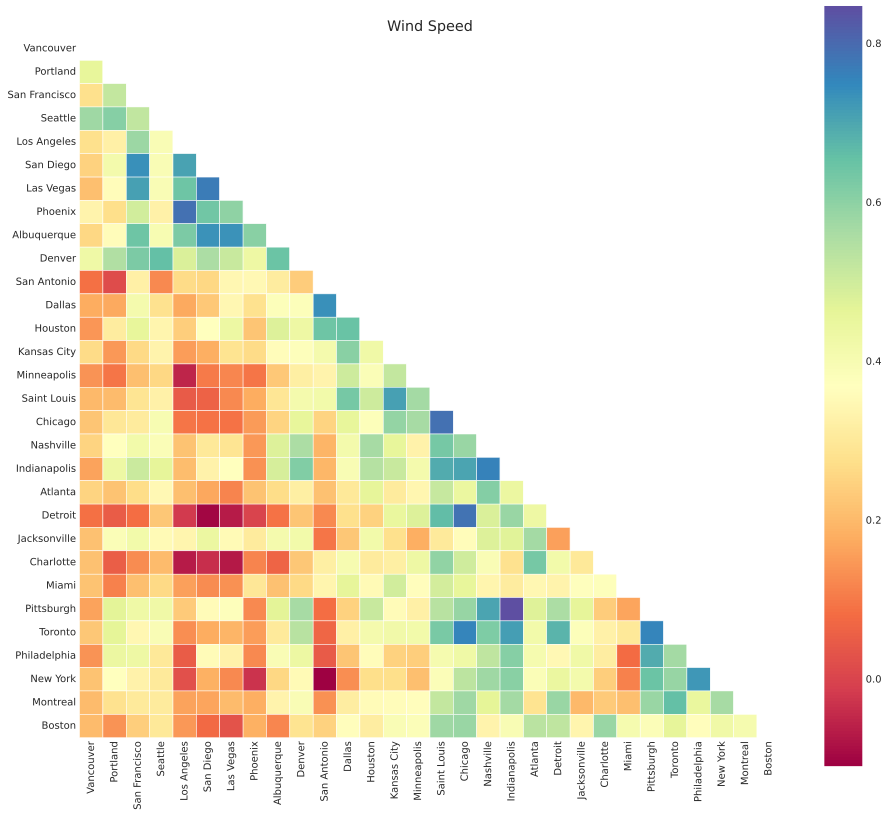

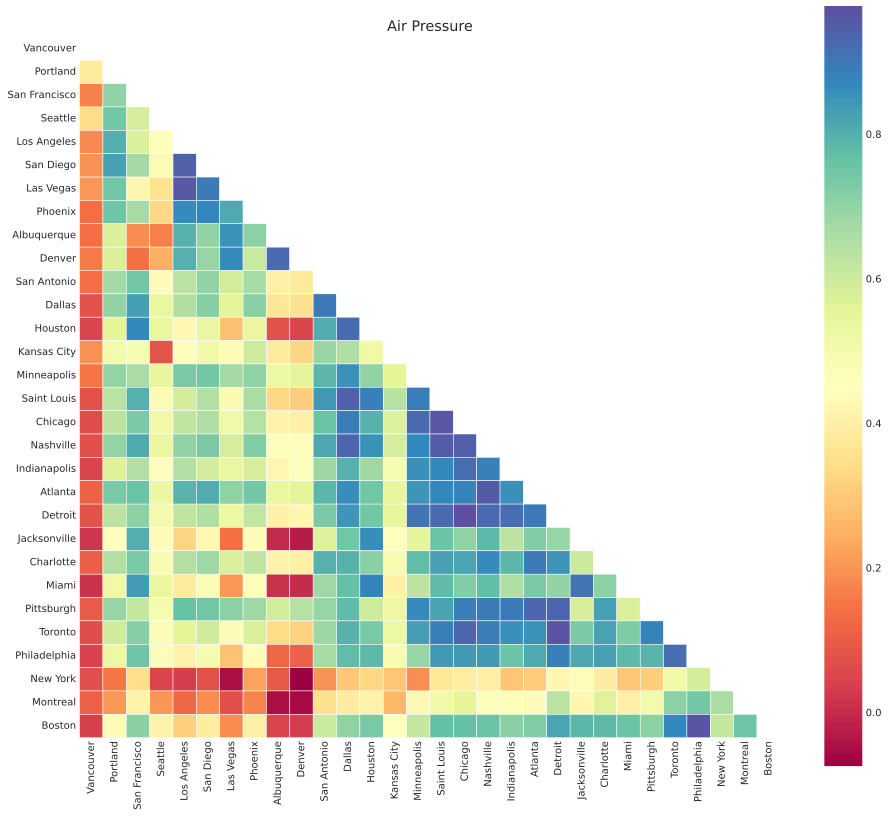

In [14]:
for name, df in {'Temperature': wd.temperature, 'Humidity': wd.humidity, 'Wind Speed': wd.wind_speed, 'Air Pressure': wd.air_pressure}.items():
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 14))
        ax = sns.heatmap(corr, mask=mask, square=True, cmap="Spectral", linewidths=.5).set_title(name)

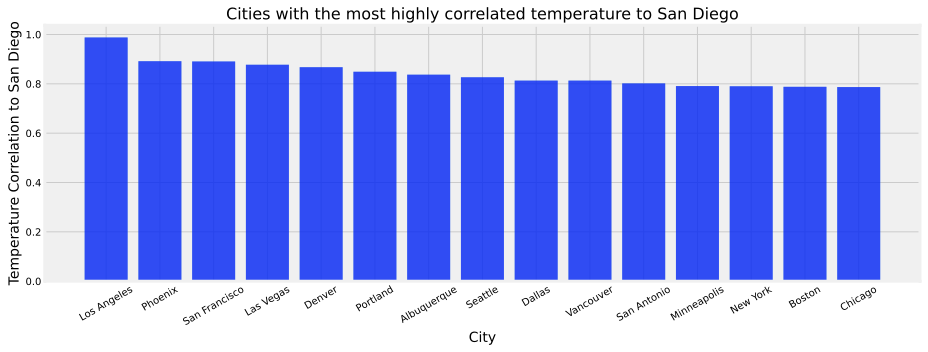

In [15]:
cities_to_plot: int = 15

sorted_temp_corrs = wd.temperature.corr()['San Diego'].sort_values(ascending=False)[1:cities_to_plot+1]

figure(figsize=(13, 5), dpi=80)
plt.bar(sorted_temp_corrs.index, sorted_temp_corrs, align='center', alpha=0.5)

opacity = 0.6
bar_width = 0.35

plt.xlabel('City')
plt.ylabel('Temperature Correlation to San Diego')
plt.title(f'Cities with the most highly correlated temperature to San Diego')

plt.xticks(range(len(sorted_temp_corrs)), (sorted_temp_corrs.index), rotation=30)
bar1 = plt.bar(sorted_temp_corrs.index, sorted_temp_corrs, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('Temperature Correlation to San Diego', fontsize=14)
plt.title(f'Cities with the most highly correlated temperature to San Diego', fontsize=16)
plt.tight_layout()
plt.show()

The results using only the correlation aren't great... We see that although some cities have highly correlated weather (temperatures in San Diego and Denver for example), the actual temperatures are quite different. 

At this point we know that relying on correlation or covariance isn't enough! So let's write a function that finds the actual distance or similarity between one column vector and each other column vector in the same matrix. This function should be able to take distance metrics such as RMSE, MAE, MAPE, etc. and should return a matrix of the same dimensions containing the error between each column and all other columns. This is similar to a correlation matrix, but instead of correlation between each column vector, we will find the distance (according to some metric) between each column vector. 

Cosine similarity should also be investigated here. 

#### Remember to normalize!! 

In [16]:
def make_error_df(df: pd.DataFrame, error_type: str) -> pd.DataFrame: 
    
    df.dropna(inplace=True)
    
    assert error_type in ('rmse', 'mse', 'mae', 'dtw'), f'error_type must be \'rmse\', \'mse\', or \'mae\', not {error_type}.'
    if error_type == 'rmse':
        squared = False
    else:
        squared = True
    
    rmse_dict = {}

    for i, col in enumerate(df.iteritems()):

        error_list = []

        for j, sub_col in enumerate(df.iteritems()):
            df.dropna()
            # use dynamic time warping
            if error_type == 'dtw':
                error: float = dtw.distance(col[1].tolist(), sub_col[1].tolist())
            else:
                error: float = round(mean_squared_error(col[1].tolist(), sub_col[1].tolist(), squared=squared), 6) 
                
            error_list.append(error)

        rmse_dict[col[0]] = error_list
        
    df = pd.DataFrame.from_dict(rmse_dict)
    df.index = df.columns

    return df


Create four heatmaps of the lower triangular matrices for each weather metric representing the RMSE between each city in our data set. Remember that the RMSE between any city and itself is zero, so we exclude the main diagonal because it doesn't offer us any additional informatin. We also know that the matrix will be symmetric about the main diagonal, so we only need to plot the lower or upper trangular matrix here. It's convention to plot the lower triangular, so that's what we do. 

CPU times: user 3.45 s, sys: 992 ms, total: 4.44 s
Wall time: 2.63 s


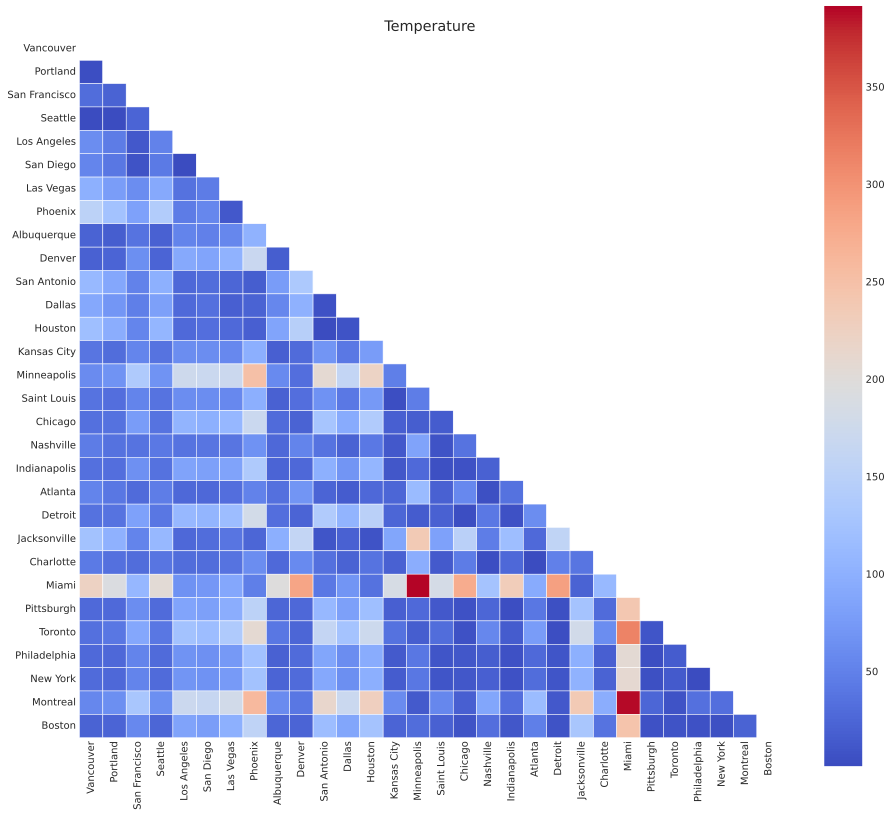

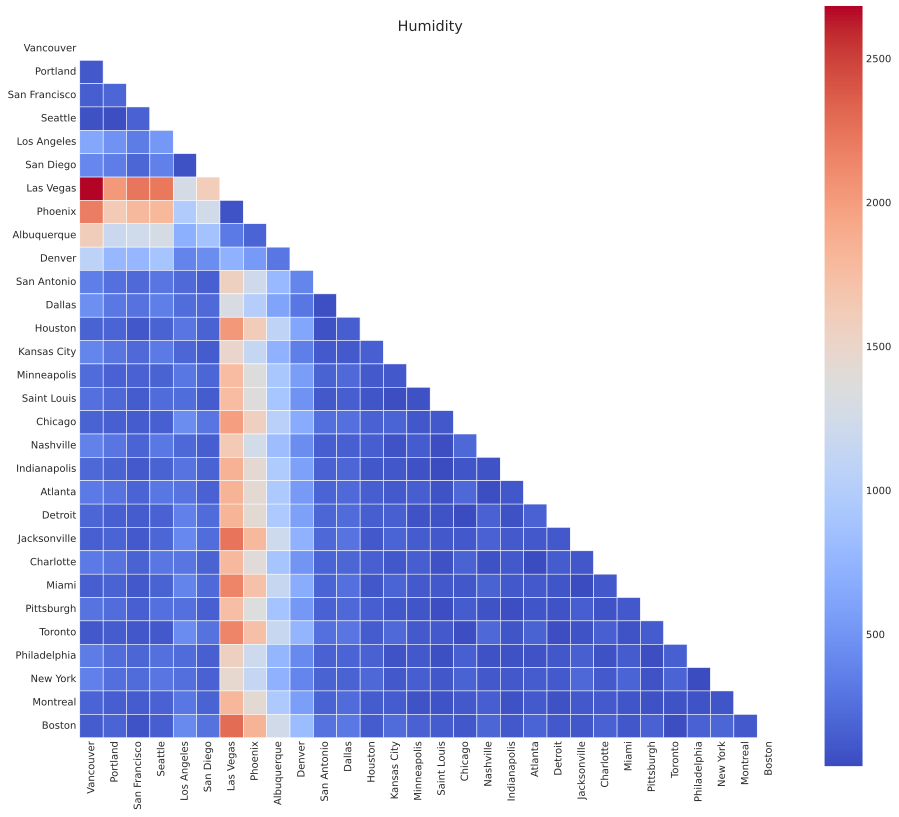

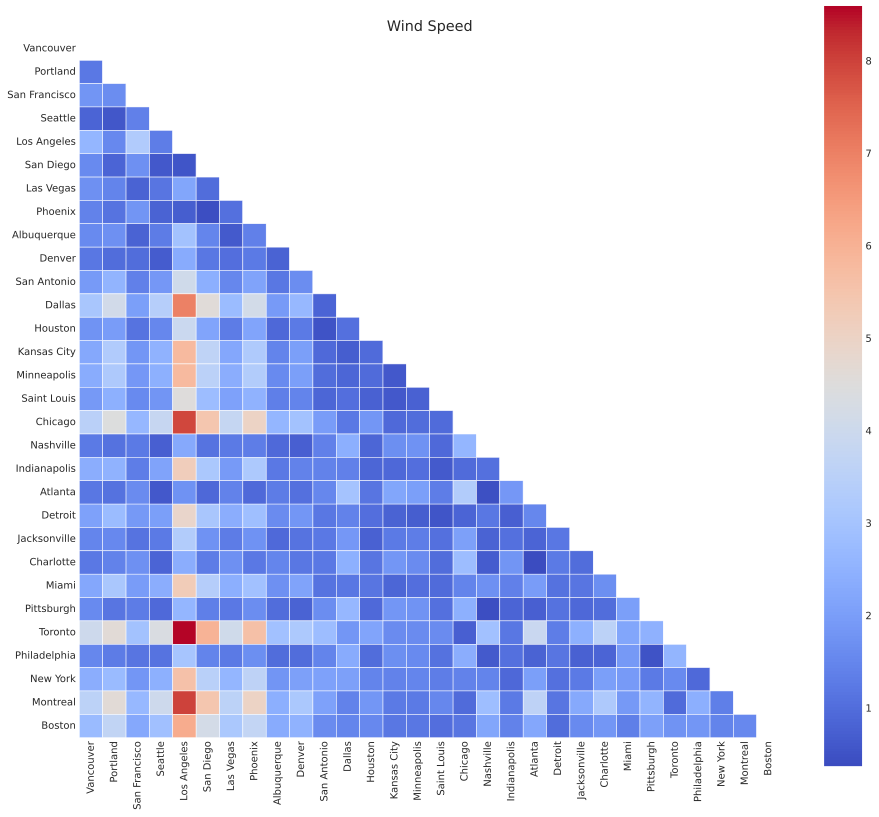

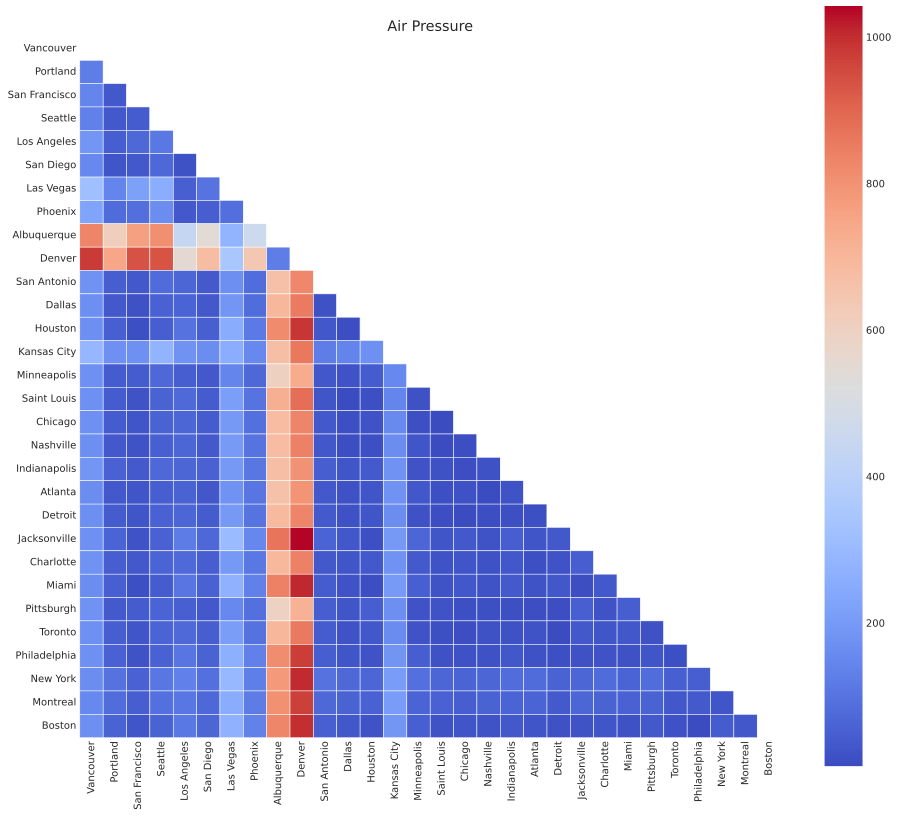

In [17]:
%%time
for name, df in {'Temperature': wd.temperature, 
                 'Humidity': wd.humidity, 
                 'Wind Speed': wd.wind_speed, 
                 'Air Pressure': wd.air_pressure}.items():
    # remove the last row of the df becasue some rows contain NaNs
    error_df = make_error_df(df=df.iloc[:-1, :], error_type=error_type)
    mask = np.zeros_like(error_df)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 14))
        ax = sns.heatmap(error_df, mask=mask, square=True, cmap="coolwarm", linewidths=.5).set_title(name)

And indeed we can see that these trangular matrices of RMSE values represent a much more meaningful, and more intuitive, relationship between cities. We can see from the temperature plot, for example, that Miami's temperature is very different from Montreal, but San Diego's temperature is very similar to Los Angeles. 

Unlike row correlations between weather metrics, these results give us something that makes intuitive sense. Let's move forward. 

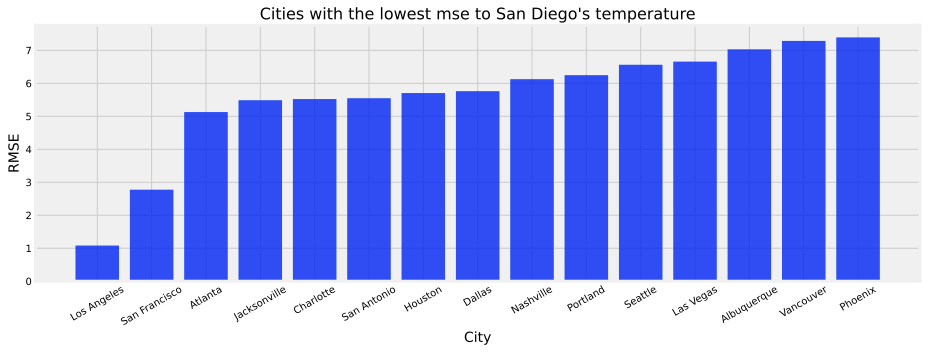

In [18]:
cities_to_plot: int = 15

sorted_temp_rmse = make_error_df(df=wd.temperature.iloc[:-1, :], error_type='rmse')['San Diego'].sort_values(ascending=True)[1:cities_to_plot+1]

figure(figsize=(13, 5), dpi=80)
plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=0.5)

opacity = 0.6
bar_width = 0.35

plt.xlabel('City')
plt.ylabel('Temperature Correlation to San Diego')
plt.title(f'Cities with the most highly correlated temperature to San Diego')

plt.xticks(range(len(sorted_temp_rmse)), (sorted_temp_rmse.index), rotation=30)
bar1 = plt.bar(sorted_temp_rmse.index, sorted_temp_rmse, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title(f'Cities with the lowest {error_type} to San Diego\'s temperature', fontsize=16)
plt.tight_layout()
plt.show()

We see the results of this plot open a few new questions, the main being: how can cold cities such as Portland, Seattle, and Vancouver be more "similar" to San Diego's temperature - based on rmse - than warmer cities such as Phoenix? Is this a mistake? 

To answer this and get a better idea of what's going on, we can plot the temperature over time for San Diego, Vancouver, and Phoenix:

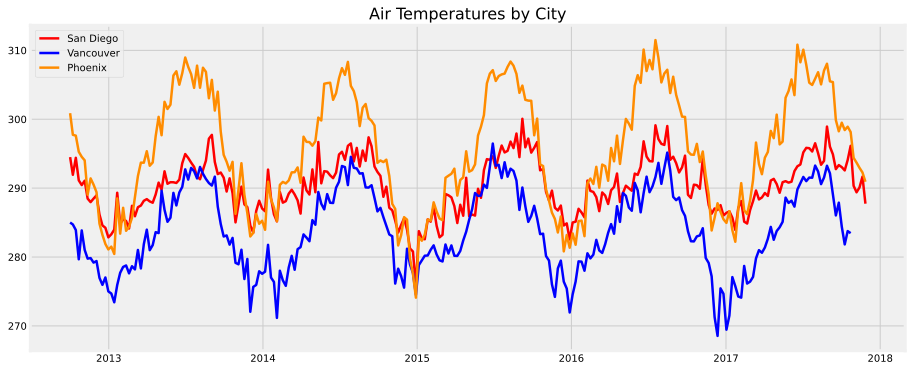

In [19]:
figure(figsize=(14, 6), dpi=80)
plt.plot(wd.temperature.index, wd.temperature['San Diego'], label = "San Diego", linestyle="-", color='red', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Vancouver'], label = "Vancouver", linestyle="-", color='blue', linewidth=2.5)
plt.plot(wd.temperature.index, wd.temperature['Phoenix'], label = "Phoenix", linestyle="-", color='darkorange', linewidth=2.5)
plt.title('Air Temperatures by City', fontsize=16)
plt.legend()
plt.show()

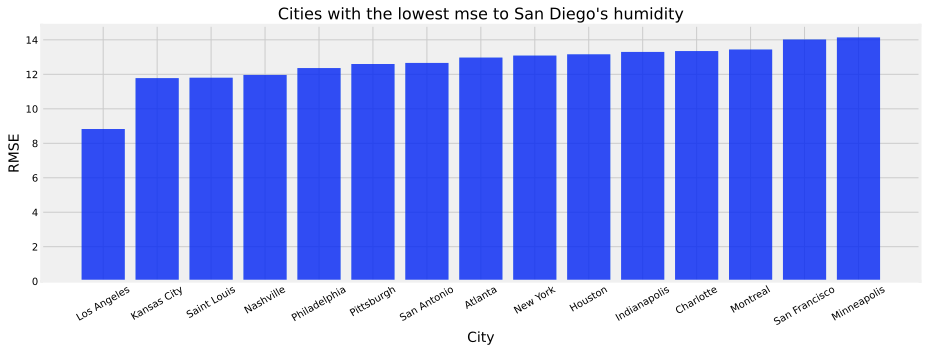

In [20]:
cities_to_plot: int = 15

sorted_humidity_rmse = make_error_df(df=wd.humidity.iloc[:-1, :], error_type='rmse')['San Diego'].sort_values(ascending=True)[1:cities_to_plot+1]

figure(figsize=(13, 5), dpi=80)
plt.bar(sorted_humidity_rmse.index, sorted_humidity_rmse, align='center', alpha=0.5)

opacity = 0.6
bar_width = 0.35

plt.xticks(range(len(sorted_humidity_rmse)), (sorted_humidity_rmse.index), rotation=30)
bar1 = plt.bar(sorted_humidity_rmse.index, sorted_humidity_rmse, align='center', alpha=opacity, color='b')
# bar2 = plt.bar(range(len(errorRateListOfSlow)), errorRateListOfSlow, bar_width, align='center', alpha=opacity, color='r', label='Slower > 6 sec.')
    
plt.xlabel('City', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title(f'Cities with the lowest {error_type} to San Diego\'s humidity', fontsize=16)
plt.tight_layout()
plt.show()

Find the intersection of the cities with the most similar temperatures and most similar humidities: 

In [21]:
temps_set = set(sorted_temp_rmse.index)
humids_set = set(sorted_humidity_rmse.index)
similar_city_set: set = (temps_set & humids_set)
similar_cities: list = list(similar_city_set)

s = '-'*10
print(f'{s} SIMILAR CITIES TO SAN DIEGO BASED ON TEMP AND HUMIDITY {s}')
for i, city in enumerate(similar_cities):
    print(f'{i+1}. {city}')

---------- SIMILAR CITIES TO SAN DIEGO BASED ON TEMP AND HUMIDITY ----------
1. San Antonio
2. Charlotte
3. Houston
4. San Francisco
5. Nashville
6. Atlanta
7. Los Angeles


## Load housing price dataset for all large, American cities

Great! We now have our similar cities (seen above), so we can load the housing price data set into memory and use that to determine the most affordable options from our similar city list. 

In order to load the housing price data, we will scrape a webpage from [kiplinger.com](kiplinger.com) using pandas. The process of extracting table data from an html page using pandas is remarkably simple, you just need to find which element in the list of dataframes represents the table that you're looking for. For us, it's the first table in the list! 

* Note that if you look in the `/data` directory that came with this notebook, you will find the housing price data alongside the weather data. I exported the housing price data to a flat file so that students could still access the data even if the kiplinger website were to go down. Feel free to use this as a backup if you don't have access to the internet or you run into trouble running the below code cell. 

In [22]:
# read the housing price data into memory
housing_url: str = 'https://www.kiplinger.com/article/real-estate/t010-c000-s002-home-price-changes-in-the-100-largest-metro-areas.html'
dfs = pd.read_html(housing_url)
housing_prices = dfs[0]

In [23]:
housing_prices.head(5)

,Metro Area,Median Home Price,% Change 1 Year,% Change Since Peak*,% Change Since Bottom†,Affordability Index
0,"Akron, Ohio","$150,000",10.1%,6.3%,62.8%,2
1,"Albany, N.Y.",215000,11.7,17.5,41.4,4
2,"Albuquerque, N.M.",180000,11.6,11.5,55.3,6
3,"Atlanta, Ga.",250000,9.5,21.3,115.0,4
4,"Augusta, Ga.",169000,7.5,13.8,37.2,1


Here we need to fix issue with mismatch between 'Saint Louis' and 'St. Louis' 

Here we split on the comma to only keep the city names we want

In [24]:
housing_prices['City'] = housing_prices['Metro Area'].str.split(',').str[0]
housing_prices[['City', 'Median Home Price']].head(5)

,City,Median Home Price
0,Akron,"$150,000"
1,Albany,215000
2,Albuquerque,180000
3,Atlanta,250000
4,Augusta,169000


In [25]:
if 'Saint Louis' in similar_cities:
    housing_prices['City'] = housing_prices['City'].replace('St. Louis', 'Saint Louis')

In [26]:
housing_prices_similar_cities = housing_prices[housing_prices['City'].isin(similar_cities)]
housing_prices_similar_cities

,Metro Area,Median Home Price,% Change 1 Year,% Change Since Peak*,% Change Since Bottom†,Affordability Index,City
3,"Atlanta, Ga.",250000,9.5,21.3,115.0,4,Atlanta
16,"Charlotte, N.C.",255000,9.7,-12.4,77.3,4,Charlotte
39,"Houston, Texas",192500,-2.0,37.1,69.5,4,Houston
49,"Los Angeles, Calif.",710000,8.1,13.1,92.2,10,Los Angeles
58,"Nashville, Tenn.",298000,10.2,69.3,94.4,5,Nashville
82,"San Antonio, Texas",175000,-1.7,44.3,55.6,7,San Antonio
84,"San Francisco, Calif.",930000,9.5,31.7,110.3,10,San Francisco


Perfect, so now we can see the median housing price for each of our most similar cities. 

To make these easier to plot, let's generate a dictionary that stores only the information we want with the city names as keys. 

### Prepare our data for plotting

In [27]:
housing_prices_dict: dict = dict(zip(housing_prices_similar_cities['City'], housing_prices_similar_cities['Median Home Price']))
housing_prices_dict

{'Atlanta': '250000',
 'Charlotte': '255000',
 'Houston': '192500',
 'Los Angeles': '710000',
 'Nashville': '298000',
 'San Antonio': '175000',
 'San Francisco': '930000'}

Now we have everything we need to visualize all of this together and get our final solution!

We just need to clean up the rest of the data we want to plot and we'll be ready to go. 

In [28]:
# find the temps and humidities for only the cities that made it through 
temps_similar_cities: pd.Series = sorted_temp_rmse[sorted_temp_rmse.index.isin(similar_cities)]
humidities_similar_cities: pd.Series = sorted_humidity_rmse[sorted_humidity_rmse.index.isin(similar_cities)]

In [29]:
# generate a temperature dict so we can use it for plotting 
temp_rmse: list = list(temps_similar_cities)
temp_name: list = list(temps_similar_cities.index)
temperature_dict = {temp_name[i]: temp_rmse[i] for i in range(len(similar_cities))}

# generate a humidity dict so we can use it for plotting 
humidity_rmse: list = list(humidities_similar_cities)
humidity_name: list = list(humidities_similar_cities.index)
humidity_dict = {humidity_name[i]: humidity_rmse[i] for i in range(len(similar_cities))}

In [30]:
hex_colors: list = [
    # blue, red, and purple
    '#42A5F5', '#7E57C2', '#AB47BC', '#EF5350', '#2196F3', '#7E57C2', 
    '#1E88E5', '#F44336', '#1976D2', '#AB47BC', '#1565C0', '#E53935'
]

In [31]:
def bubble_chart(similar_cities: list, housing_prices_dict: dict, temperature_dict: dict, humidity_dict: dict):
    
    bubble_scale = 120
    
    # define empty lists to fill with ordered data 
    ordered_housing_prices: list = []
    ordered_temps: list = []
    ordered_humidities: list = []
    rank: list = []
    
    # we need to do this to make sure all of the lists that store our information are in the same order 
    for i, city in enumerate(similar_cities):
        ordered_housing_prices.append(int(housing_prices_dict[city]) / bubble_scale)
        ordered_temps.append(temperature_dict[city])
        ordered_humidities.append(humidity_dict[city])
        rank.append(i+1)
        
    #create scatter plot
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # we need to give the axes a little help here to include our bubbles 
    ax.axis([(min(ordered_temps)-1),(max(ordered_temps)+1),(min(ordered_humidities)-1),(max(ordered_humidities)+1)]) 
    opacity = 0.5
    colors = hex_colors[:len(similar_cities)]
    # create the actual scatter plot 
    ax.scatter(ordered_temps, ordered_humidities, s=ordered_housing_prices, marker='o', c=colors, alpha=opacity, label=ordered_housing_prices)
    
    # invert the axes so larger values are up and to the right 
    ax.invert_xaxis()
    ax.invert_yaxis()

    #label each bubble
    for name, humids, temps in zip(similar_cities, ordered_humidities, ordered_temps):
        plt.annotate(name ,xy=(temps, humids), xytext=(0,0), textcoords="offset points", ha="center", va="bottom", fontsize=12, weight='bold')

    #Label axis
    plt.xlabel('← Less Similar Temperatures            More Similar Temperatures →', fontsize=17)
    plt.ylabel('← Less Similar Humidities    More Similar Humidities →', fontsize=16)
    plt.title(f'Bubble chart showing Temp, Humidity, and Housing Price Magnitude for similar cities '\
               f'\n Distance Metric: {error_type} | Time Aggregation: {time_agg}', fontsize=16)
    plt.show()

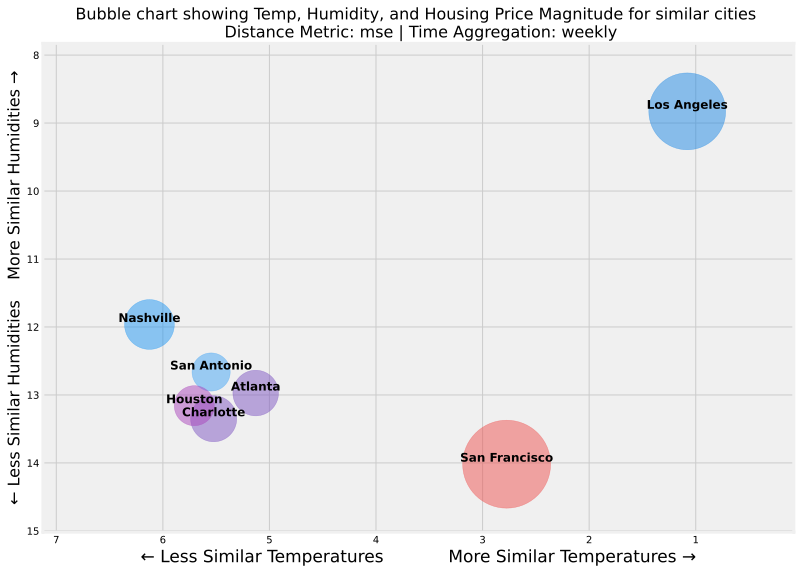

In [32]:
bubble_chart(similar_cities=similar_cities, housing_prices_dict=housing_prices_dict, 
             temperature_dict=temperature_dict, humidity_dict=humidity_dict)

### So now we're finished! 

We can see bubbles in the upper right corner are more similar in temperature and humidity, and bubbles in the lower left corner are less similar. We can also see the magnitude of the median housing cost in each city by the size of the bubble. It looks like Los Angeles has very similar weather, but is very expensive... However, we can see cities such as Nashville, Atlanta, San Antonio, Charlotte, Houston, and Dallas also have similar weather with much more affordable housing! Of that group, we can see that San Antonio has the cheapest housing and Nashville has the most expensive. So that about wraps it up! 

The keen reader is encouraged to implement additional similarity tests and re-run the second half of the notebook. What would our final bubble chart look like if we used cosine similarity instead of rmse? What if we used mean absolute error (mae)? (This one is already implemented, so you can change the value in one cell and see the results if you'd like!)

Could we use all four of the weather metrics and not just temperatue and humidity? It was easier to visualize only two metrics because we could make plots in two dimensions, but perhaps we would get more meaningful results if we found the rmse over all four weather metrics! 

What if we weighted how important each metric was? I think we would need to ask James for his preferences, but perhaps temperature and wind speed are the most important, and humidity and barametric pressure don't matter quite as much! Then we could apply weights of 0.3 to temp and wind speed and 0.2 to humidity and pressure. What would the resulting bubble chart look like then? 

The possabilities are endless... 